# Machine Failure Classification using sensor data

By: Nathália Alvim

E-mail: natalvimdesouza@hotmail.com

Dataset is avaible on kaggle.

https://www.kaggle.com/datasets/mujtabamatin/dataset-for-machine-failure-detection

The dataset has 1000 samples and 6 variables.


The dataset consists of the following features:

- Temperature (°C): Continuous data representing the temperature at the machine's
critical points. Higher temperatures may indicate potential issues due to overheating.

- Vibration (Hz): Frequency of machine vibrations. Abnormal vibrations can signal mechanical misalignment, imbalance, or wear.

- Power Usage (kW): Power consumption levels of the machine. Spikes in power usage may indicate increased load or potential mechanical issues.

- Humidity (%): Environmental humidity around the machine. High humidity levels could affect machine performance and lead to failure over time.

- Machine Type: Categorical data indicating the type of machine (e.g., "Drill", "Lathe", "Mill"). Different machine types may have unique failure patterns.

Target Variable:

- Failure Risk: A binary label where 0 indicates normal operation, and 1 indicates that the machine is at risk of failure.

## Install Packages

In [15]:
#Installing Lazy Predict
!pip install lazypredict
!pip install tensorflow
!pip install imblearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]d-learn]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


##Importing dataset

In [50]:
#Import packages for pre processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import auc, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
#Import packages tensor flow
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier

In [18]:
#Loading the dataset
file_path = '/workspaces/Machine-Learning/machine_failure_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.97,57.00,8.65,20.46,Mill,1
1,68.62,54.62,9.71,25.70,Lathe,0
2,76.48,50.30,8.42,27.93,Drill,1
3,85.23,46.77,9.38,39.44,Lathe,1
4,67.66,53.49,6.21,32.78,Drill,1


In [19]:
# General information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   1000 non-null   float64
 1   Vibration     1000 non-null   float64
 2   Power_Usage   1000 non-null   float64
 3   Humidity      1000 non-null   float64
 4   Machine_Type  1000 non-null   object 
 5   Failure_Risk  1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB
None


## Class Balacing

In [20]:
# Class Balancing
# First i'll apply for the categorical variables and after i'll do with the binary variable

categorical = 'Machine_Type'

#Available categories

categories = df[categorical].unique()

#Counting
counting = df[categorical].value_counts()

print(categories)
print(counting)

['Mill' 'Lathe' 'Drill']
Machine_Type
Lathe    338
Drill    334
Mill     328
Name: count, dtype: int64


In [21]:
#Binary variable

binary = 'Failure_Risk'

#Available categories

categories = df[binary].unique() # 0 = Normal operation \\ 1 = Risk of failure

#Counting
counting = df[binary].value_counts()

print(categories)
print(counting)

[1 0]
Failure_Risk
0    700
1    300
Name: count, dtype: int64


## Descriptive statistics

In [22]:
# Calculate mean, median, and mode for each numerical column
# Select only numerical columns (nc) and exclude the binary variable
# Select only numerical columns and exclude a specific one
nc = df.select_dtypes(include=['number']).drop(columns=['Failure_Risk'])

mean = nc.mean()
median = nc.median()
mode = nc.mode().iloc[0]  # Takes the first mode found for each column
std = nc.std()  # Standard deviation
cv = std / mean  # Coefficient of Variation


print("\nMean of each column:")
print(mean)

print("\nMedian of each column:")
print(median)

print("\nMode of each column:")
print(mode)

print("\nStandard Deviation of each column:")
print(std)

print("\nCoefficient of Variation (CV) of each column:")
print(cv)


Mean of each column:
Temperature   70.19
Vibration     50.35
Power_Usage   10.01
Humidity      29.91
dtype: float64

Median of each column:
Temperature   70.25
Vibration     50.32
Power_Usage   10.00
Humidity      30.00
dtype: float64

Mode of each column:
Temperature   37.59
Vibration     35.30
Power_Usage    3.96
Humidity      15.35
Name: 0, dtype: float64

Standard Deviation of each column:
Temperature   9.79
Vibration     4.99
Power_Usage   1.97
Humidity      5.14
dtype: float64

Coefficient of Variation (CV) of each column:
Temperature   0.14
Vibration     0.10
Power_Usage   0.20
Humidity      0.17
dtype: float64


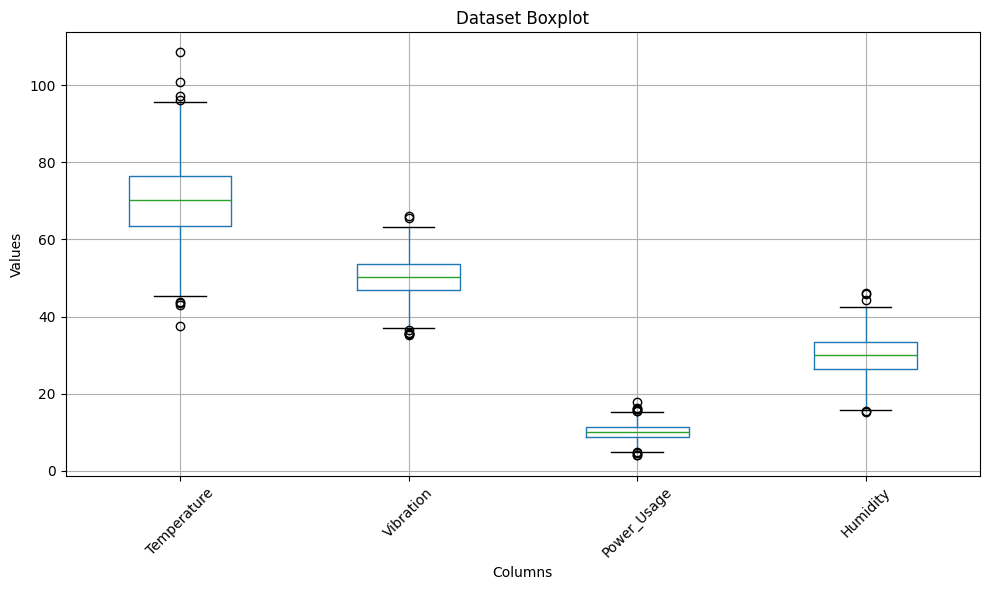

In [23]:
# Boxpot
# Generate boxplot to visualize distribution and possible outliers
plt.figure(figsize=(10, 6))
nc.boxplot()
plt.title("Dataset Boxplot")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

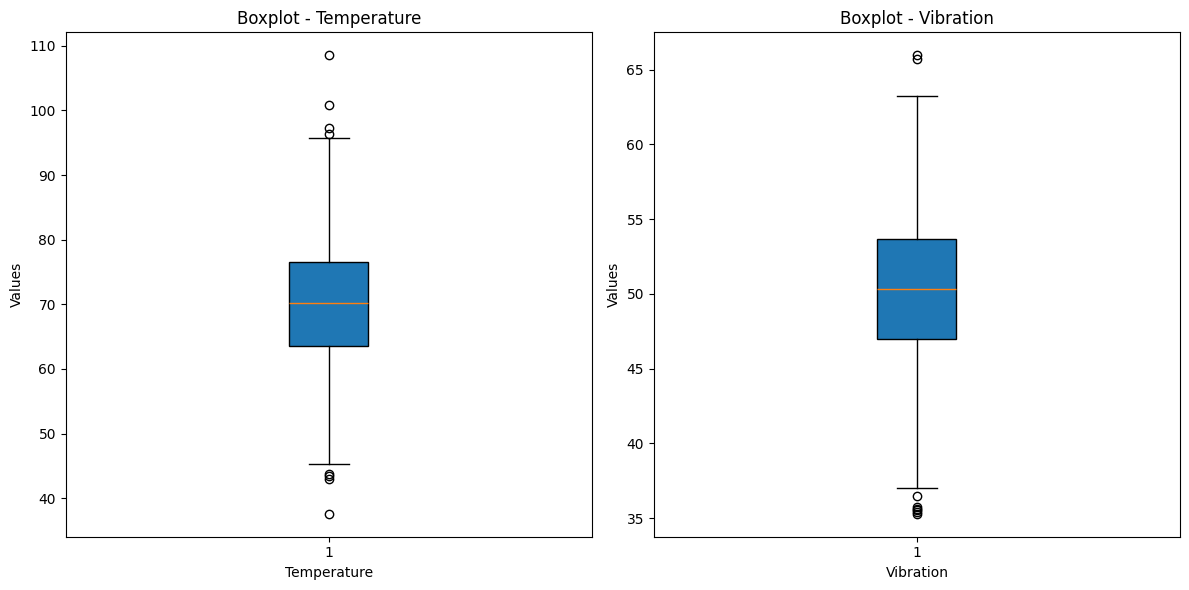

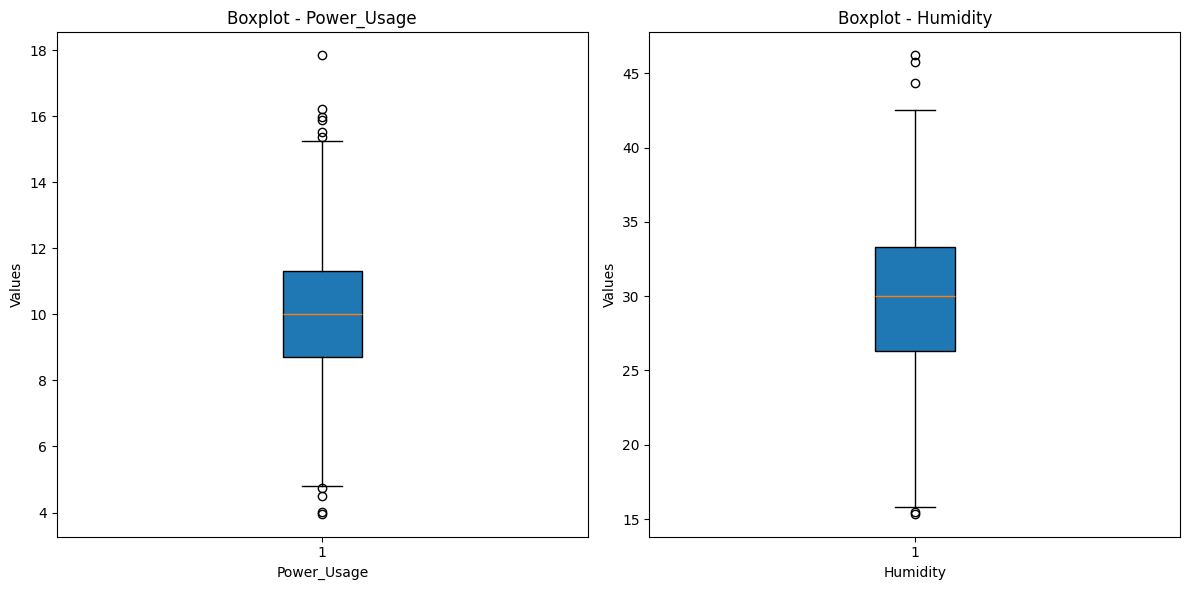

In [24]:
# Generate paired boxplots to save space and for better visualization
columns = nc.columns
num_columns = len(columns)

# Iterate over the columns in pairs
for i in range(0, num_columns, 2):
    # Set up the subplot for 2 side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First boxplot
    axes[0].boxplot(nc[columns[i]].dropna(), vert=True, patch_artist=True)
    axes[0].set_title(f"Boxplot - {columns[i]}")
    axes[0].set_xlabel(columns[i])
    axes[0].set_ylabel("Values")

    # Second boxplot (if it exists)
    if i + 1 < num_columns:
        axes[1].boxplot(nc[columns[i + 1]].dropna(), vert=True, patch_artist=True)
        axes[1].set_title(f"Boxplot - {columns[i + 1]}")
        axes[1].set_xlabel(columns[i + 1])
        axes[1].set_ylabel("Values")
    else:
        # Remove the second subplot if there's no second column
        fig.delaxes(axes[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Normality of the dataset

- Shapiro-Wilk

- D’Agostino-Pearson

- Anderson-Darling

In [25]:
def normality_tests_summary(dataframe):
    numeric_cols = dataframe.select_dtypes(include=['number'])
    results = []

    for col in numeric_cols.columns:
        col_data = numeric_cols[col].dropna()

        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = shapiro(col_data)
        shapiro_result = "Normal" if shapiro_p > 0.05 else "Not normal"

        # D’Agostino and Pearson Test
        dagostino_stat, dagostino_p = normaltest(col_data)
        dagostino_result = "Normal" if dagostino_p > 0.05 else "Not normal"

        # Anderson-Darling Test
        anderson_result_obj = anderson(col_data)
        ad_stat = anderson_result_obj.statistic
        # Compare with 5% significance level
        ad_result = "Normal" if ad_stat < anderson_result_obj.critical_values[2] else "Not normal"

        results.append({
            "Column": col,
            "Shapiro-Wilk (p)": round(shapiro_p, 4),
            "Shapiro Result": shapiro_result,
            "D’Agostino (p)": round(dagostino_p, 4),
            "D’Agostino Result": dagostino_result,
            "Anderson-Darling (stat)": round(ad_stat, 4),
            "Anderson Result (5%)": ad_result
        })

    return pd.DataFrame(results)


In [26]:
summary_df = normality_tests_summary(nc)
print(summary_df)

        Column  Shapiro-Wilk (p) Shapiro Result  D’Agostino (p)  \
0  Temperature              0.63         Normal            0.28   
1    Vibration              0.73         Normal            0.74   
2  Power_Usage              0.72         Normal            0.39   
3     Humidity              0.48         Normal            0.27   

  D’Agostino Result  Anderson-Darling (stat) Anderson Result (5%)  
0            Normal                     0.35               Normal  
1            Normal                     0.17               Normal  
2            Normal                     0.21               Normal  
3            Normal                     0.31               Normal  


In [28]:
#Convert categorical variable to 1, 2, 3 variable
label_encoder = LabelEncoder()
df['Machine_Type_encoded'] = label_encoder.fit_transform(df['Machine_Type'])

In [29]:
for i, category in enumerate(label_encoder.classes_):
    print(f"{category} -> {i + 1}")

print(df.head())

Drill -> 1
Lathe -> 2
Mill -> 3
   Temperature  Vibration  Power_Usage  Humidity Machine_Type  Failure_Risk  \
0        74.97      57.00         8.65     20.46         Mill             1   
1        68.62      54.62         9.71     25.70        Lathe             0   
2        76.48      50.30         8.42     27.93        Drill             1   
3        85.23      46.77         9.38     39.44        Lathe             1   
4        67.66      53.49         6.21     32.78        Drill             1   

   Machine_Type_encoded  
0                     2  
1                     1  
2                     0  
3                     1  
4                     0  


In [30]:
#Remove Machine_Type and renomed Machine_Type_encoded to Machine_Type
df.drop('Machine_Type', axis=1, inplace=True)
df.rename(columns={'Machine_Type_encoded': 'Machine_Type'}, inplace=True)
print(df.head())

   Temperature  Vibration  Power_Usage  Humidity  Failure_Risk  Machine_Type
0        74.97      57.00         8.65     20.46             1             2
1        68.62      54.62         9.71     25.70             0             1
2        76.48      50.30         8.42     27.93             1             0
3        85.23      46.77         9.38     39.44             1             1
4        67.66      53.49         6.21     32.78             1             0


In [31]:
# Correlation with the Failure_Risk variable
correlations = df.select_dtypes(include=['number']).corr()["Failure_Risk"].drop("Failure_Risk")
print(correlations)

Temperature     0.03
Vibration      -0.00
Power_Usage     0.02
Humidity       -0.02
Machine_Type   -0.03
Name: Failure_Risk, dtype: float64


## Pearson correlation map




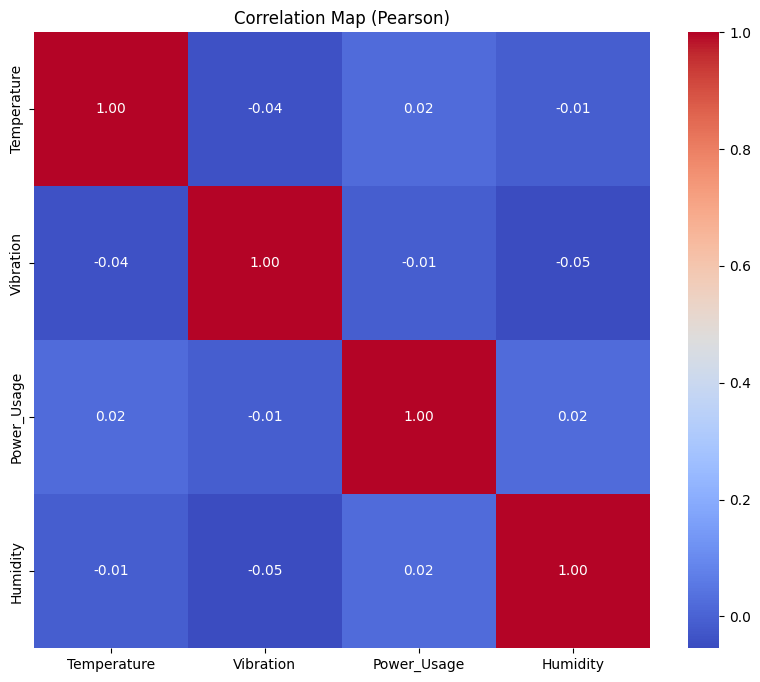

In [32]:
# Pearson Correlation Map
# Calculate the correlation matrix (Pearson coefficient)
pearson_correlation = nc.corr(method='pearson')

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("Correlation Map (Pearson)")
plt.show()

### Conclusion:

The data set follows a normal distribution by tests performed such as Shapiro Wilk.
A graph was generated in order to define the linearity of the system, thus concluding that the system is non-linear.
Finally, the Pearson correlation map was created to see the relationship between the variables.

In summary:

-> Non-linear

-> Normal Distribution

## Train and Test

In [33]:
# Separate features (X) and target (y)
X = df.drop("Failure_Risk", axis=1)
y = df["Failure_Risk"]

In [34]:
#80 training and 20 for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
#Scale numerical features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled)
print(X_train_scaled)

[[0.59881943 0.57430317 0.86452453 0.07172202 0.5       ]
 [0.66833217 0.30530478 0.48401541 0.45549354 0.5       ]
 [0.22157599 0.46236915 0.49445743 0.36418088 1.        ]
 [0.42207956 0.69413978 0.26547422 0.42249562 0.5       ]
 [0.33490121 0.57008573 0.6561486  0.41541897 1.        ]
 [0.66089364 0.64216222 0.44845501 0.67765395 0.        ]
 [0.35626736 0.40646748 0.63677533 0.34450773 0.        ]
 [0.36924826 0.17507992 0.3980213  0.19432889 0.5       ]
 [0.61299183 0.52184111 0.46267428 0.44956933 0.        ]
 [0.38891716 0.67332872 0.44939258 0.6381641  1.        ]
 [0.44327067 0.50333147 0.3432249  0.55079129 0.5       ]
 [0.52661968 0.22561467 0.52338241 0.60915907 0.        ]
 [0.64309219 0.32367609 0.4621744  0.42593507 1.        ]
 [0.40958587 0.51114808 0.72084199 0.49595391 1.        ]
 [0.55142189 0.65642414 0.19868668 0.4242386  0.        ]
 [0.38358779 0.4312236  0.47609562 0.54412322 0.5       ]
 [0.53080792 0.50117086 0.18625857 0.34000555 0.        ]
 [0.67805819 0

I normalized everything, so if the Machine Type was 1, now is 0, if it was 2 now is 0.5 and if it was 3 now is 1.

Drill -> 0

Lathe -> 0.5

Mill -> 1

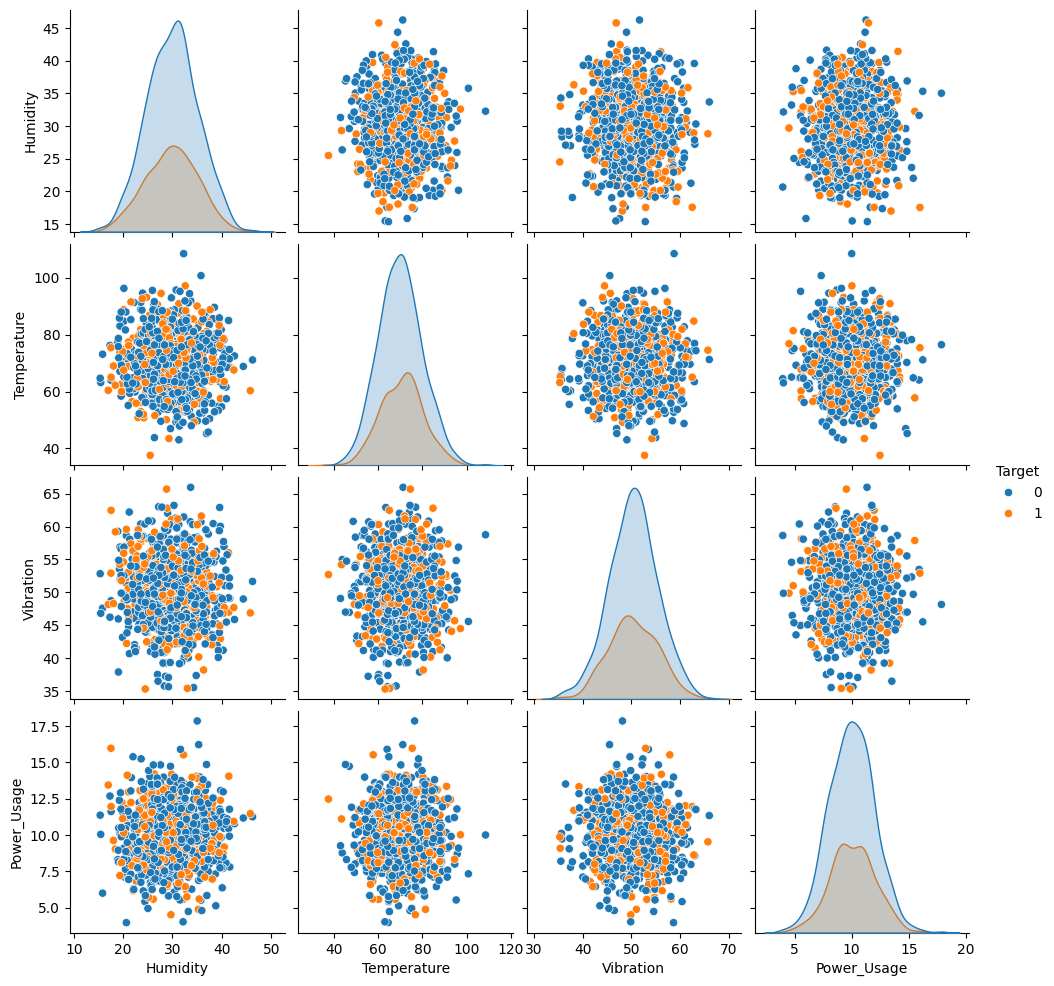

In [36]:
#Visually see how classes are distributed across variable combinations:
data_plot = pd.DataFrame(X, columns=['Humidity', 'Temperature', 'Vibration', 'Power_Usage'])
data_plot['Target'] = y
sns.pairplot(data_plot, hue='Target')

Visually, the classes are overlapping, making it difficult to separate them. Therefore, linear methods would not work as expected. And they all follow a normal distribution, as previously presented.

## Models

In [37]:
# LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and compare models
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Display the results
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 235, number of negative: 565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293750 -> initscore=-0.877240
[LightGBM] [Info] Start training from score -0.877240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [38]:
# Top 10 models
print(models.head(10))

                             Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                         
LabelPropagation                 0.59               0.54     0.54      0.60   
LabelSpreading                   0.59               0.54     0.54      0.60   
ExtraTreesClassifier             0.67               0.54     0.54      0.61   
ExtraTreeClassifier              0.59               0.52     0.52      0.59   
SGDClassifier                    0.67               0.52     0.52      0.58   
PassiveAggressiveClassifier      0.62               0.51     0.51      0.59   
DecisionTreeClassifier           0.57               0.51     0.51      0.57   
KNeighborsClassifier             0.62               0.50     0.50      0.58   
DummyClassifier                  0.68               0.50     0.50      0.54   
AdaBoostClassifier               0.68               0.50     0.50      0.54   

                             Time Taken  
Model    

## Rebalancing classes


Before we train the model, we must rebalance the classes, as metrics like ROC AUC and Balanced Accuracy are "guessing" values ​​randomly.

In [39]:
#Rebalancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled)
print(y_train_resampled)

      Temperature  Vibration  Power_Usage  Humidity  Machine_Type
0           67.08      44.89         9.02     30.17             2
1           70.47      42.03         9.41     37.97             1
2           66.90      59.69        12.86     28.42             1
3           65.67      45.98        10.01     30.62             0
4           85.51      44.28        13.81     36.19             0
...           ...        ...          ...       ...           ...
1125        65.89      48.60         9.17     30.22             0
1126        62.53      56.63        10.75     19.13             1
1127        63.96      50.59         8.87     33.23             0
1128        72.76      56.09        11.02     25.64             0
1129        62.59      50.74         9.42     24.87             1

[1130 rows x 5 columns]
0       1
1       1
2       0
3       0
4       0
       ..
1125    1
1126    1
1127    1
1128    1
1129    1
Name: Failure_Risk, Length: 1130, dtype: int64


In [40]:
#Scaler again
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [41]:
# LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and compare models with resampled data
models_2, predictions_2 = clf.fit(X_train_scaled, X_test_scaled, y_train_resampled, y_test)

# Display the results
print(models_2)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
PassiveAggressiveClassifier        0.59               0.59     0.59      0.60   
LabelSpreading                     0.57               0.54     0.54      0.58   
LabelPropagation                   0.57               0.54     0.54      0.58   
RandomForestClassifier             0.58               0.53     0.53      0.58   
KNeighborsClassifier               0.54               0.52     0.52      0.55   


In [42]:
# Top 10 models_2
print(models_2.head(10))

                             Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                         
PassiveAggressiveClassifier      0.59               0.59     0.59      0.60   
LabelSpreading                   0.57               0.54     0.54      0.58   
LabelPropagation                 0.57               0.54     0.54      0.58   
RandomForestClassifier           0.58               0.53     0.53      0.58   
KNeighborsClassifier             0.54               0.52     0.52      0.55   
ExtraTreesClassifier             0.57               0.51     0.51      0.57   
BernoulliNB                      0.51               0.51     0.51      0.52   
LGBMClassifier                   0.56               0.51     0.51      0.57   
DecisionTreeClassifier           0.53               0.50     0.50      0.54   
DummyClassifier                  0.68               0.50     0.50      0.54   

                             Time Taken  
Model    

Separability between classes is still weak, even with balanced data.

→ May indicate overlap between classes or features with little predictive power.

## Test with XGBoost

In [43]:
# Train XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train_resampled)

# Predict on test set
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       135
           1       0.31      0.31      0.31        65

    accuracy                           0.55       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.55      0.55      0.55       200


Confusion Matrix:
[[90 45]
 [45 20]]

ROC AUC Score: 0.48


## Test with RadomForest

In [44]:
brf = BalancedRandomForestClassifier(random_state=42)
brf.fit(X_train_scaled, y_train_resampled)

# Prediction on test data
y_pred = brf.predict(X_test_scaled)
y_prob = brf.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       135
           1       0.36      0.37      0.36        65

    accuracy                           0.58       200
   macro avg       0.52      0.53      0.53       200
weighted avg       0.58      0.58      0.58       200


Confusion Matrix:
[[92 43]
 [41 24]]

ROC AUC Score: 0.50


## Adding new data to improve class balance

I'll use Autoencode to add some data

In [45]:
# Select only data with failures
df_failures = df[df["Failure_Risk"] == 1]

# Only numerical columns
features = ["Humidity", "Temperature", "Vibration", "Power_Usage","Machine_Type"]
X_failure = df_failures[features].values

# Normalize the data
scaler = MinMaxScaler()
X_failure_scaled = scaler.fit_transform(X_failure)

# Latent space dimension
latent_dim = 2
input_dim = X_failure_scaled.shape[1]

In [46]:
# --- Encoder ---
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(16, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(h)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(h)

2025-08-21 18:25:19.561981: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [47]:
# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [48]:
# --- Decoder ---
decoder_h = layers.Dense(16, activation='relu')
decoder_output = layers.Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
outputs = decoder_output(h_decoded)

In [52]:
# Define encoder and decoder separately for generation later
encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder_input = layers.Input(shape=(latent_dim,))
decoder_model = models.Model(decoder_input, decoder_output(decoder_h(decoder_input)), name='decoder')

In [53]:
# --- VAE as subclassed model ---
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Calculate losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [54]:
# --- Compile and Train ---
vae = VAE(encoder, decoder_model)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_failure_scaled, epochs=100, batch_size=32)

Epoch 1/100


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 0.2182 - loss: 0.5483 - reconstruction_loss: 0.3301
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.1366 - loss: 0.4549 - reconstruction_loss: 0.3183 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0859 - loss: 0.3995 - reconstruction_loss: 0.3136 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0511 - loss: 0.3530 - reconstruction_loss: 0.3019 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0324 - loss: 0.3324 - reconstruction_loss: 0.3000 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0224 - loss: 0.3269 - reconstruction_loss: 0.3045 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0173 - loss: 0.3085 - reconstruction_loss: 0.2912 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0147 - loss: 0.3170 - reconstruction_loss: 0.3023 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0127 - loss: 0.3049 - reconst

## Create a new dataset

Generate synthetic data + the old dataset

In [55]:
# Generate synthetic failure data
z_samples = np.random.normal(size=(300, latent_dim))
generated_data = decoder_model.predict(z_samples)
generated_data = scaler.inverse_transform(generated_data)

# Create new DataFrame for synthetic failures
df_synthetic = pd.DataFrame(generated_data, columns=df_failures.drop("Failure_Risk", axis=1).columns)
df_synthetic["Failure_Risk"] = 1

# Combine with original dataset
df_combined = pd.concat([df, df_synthetic], ignore_index=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## Train and Test Split

In [56]:
# Separate features and target
X = df_combined.drop("Failure_Risk", axis=1)
y = df_combined["Failure_Risk"]

In [57]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
# Scale features again
scaler_final = MinMaxScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)

## Lazy Classifier again

In [59]:
# LazyClassifier to compare models
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models_3, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 480, number of negative: 560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461538 -> initscore=-0.154151
[LightGBM] [Info] Start training from score -0.154151


In [60]:
# Display model comparison
print("Top models after VAE-based balancing:")
print(models_3)

Top models after VAE-based balancing:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.75               0.74     0.74      0.74   
KNeighborsClassifier               0.75               0.73     0.73      0.74   
CalibratedClassifierCV             0.75               0.73     0.73      0.73   
RidgeClassifierCV                  0.75               0.73     0.73      0.73   
RidgeClassifier                    0.75               0.73     0.73      0.73   
SVC                                0.75               0.73     0.73      0.73   
PassiveAggressiveClassifier        0.75               0.73     0.73      0.73   
NuSVC                              0.75               0.73     0.73      0.73   
LogisticRegression                 0.75               0.73     0.73      0.73   
LinearSVC                          0.75               0.73     0.73    

In [61]:
# Top 10 models
print(models_3.head(10))

                             Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                         
BernoulliNB                      0.75               0.74     0.74      0.74   
KNeighborsClassifier             0.75               0.73     0.73      0.74   
CalibratedClassifierCV           0.75               0.73     0.73      0.73   
RidgeClassifierCV                0.75               0.73     0.73      0.73   
RidgeClassifier                  0.75               0.73     0.73      0.73   
SVC                              0.75               0.73     0.73      0.73   
PassiveAggressiveClassifier      0.75               0.73     0.73      0.73   
NuSVC                            0.75               0.73     0.73      0.73   
LogisticRegression               0.75               0.73     0.73      0.73   
LinearSVC                        0.75               0.73     0.73      0.73   

                             Time Taken  
Model    

## Testing SGDClassifier, Random Forest and Gradient Boosting

Using scores like:

- accuracy
- f1
- recall
- precision
- roc_AUC
- Cross Validation

In [62]:
# Scorers for evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'roc_auc': make_scorer(roc_auc_score)
}

In [63]:
# Initializing the models
models = {
    'SGDClassifier': SGDClassifier(random_state=42, loss='log_loss', penalty='l2', max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=100),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
}



In [64]:
# Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [65]:
# Running the models
for name, model in models.items():
    print(f"\n{name}:")

    pipeline = ImbPipeline(steps=[
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    results = cross_validate(
        pipeline, X, y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )

    for metric in scoring.keys():
        print(f"{metric.capitalize()}: {np.mean(results['test_' + metric]):.4f}")


SGDClassifier:


Accuracy: 0.6954
F1: 0.6562
Recall: 0.6333
Precision: 0.7550
Roc_auc: 0.6910

RandomForest:
Accuracy: 0.7400
F1: 0.6600
Recall: 0.5483
Precision: 0.8353
Roc_auc: 0.7263

GradientBoosting:
Accuracy: 0.7377
F1: 0.6599
Recall: 0.5533
Precision: 0.8215
Roc_auc: 0.7245

LogisticRegression:
Accuracy: 0.7662
F1: 0.6651
Recall: 0.5050
Precision: 0.9777
Roc_auc: 0.7475


## Optimizing hyperparameters

I'll choose Random Forest for my model

In [66]:
# Pipeline including scaling and SMOTE
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    ))
])

In [67]:
# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

In [68]:
# Grid Search with F1 as scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l2'], 'classifier__solver': ['lbfgs', 'liblinear']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [69]:
# Best hyperparameters
print("Best Parameters:")
print(grid_search.best_params_)

Best Parameters:
{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [70]:
# Evaluation on test set
print("\nClassification Report on Test Set:")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      0.99      0.81       140
           1       0.97      0.47      0.63       120

    accuracy                           0.75       260
   macro avg       0.82      0.73      0.72       260
weighted avg       0.81      0.75      0.72       260



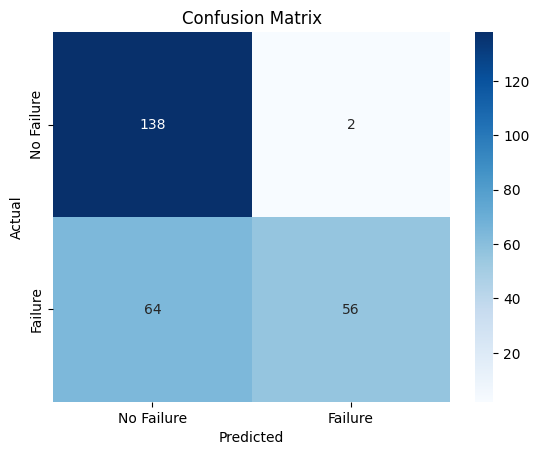

In [71]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

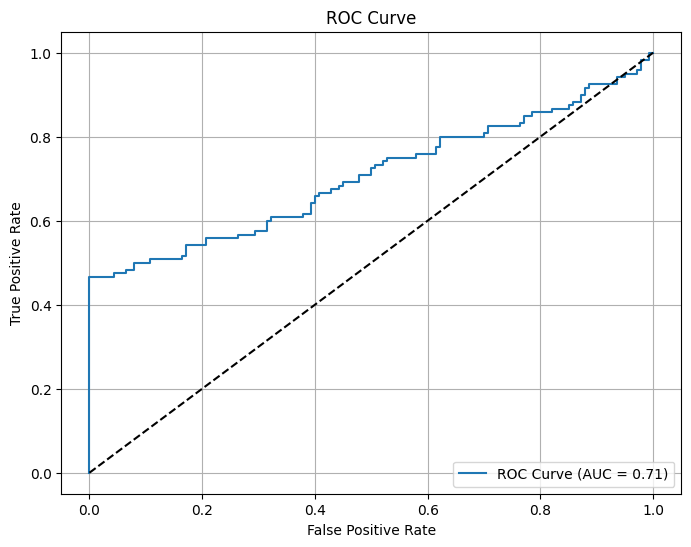

In [72]:
# ROC Curve and AUC
y_prob = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Testing for more recalls

In [73]:
# Probability predictions for class 1 (failure)
y_prob = grid_search.predict_proba(X_test)[:, 1]

# Testing different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
recalls = []
precisions = []

for threshold in thresholds:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    report = classification_report(y_test, y_pred_thresh, output_dict=True)
    recalls.append(report['1']['recall'])
    precisions.append(report['1']['precision'])


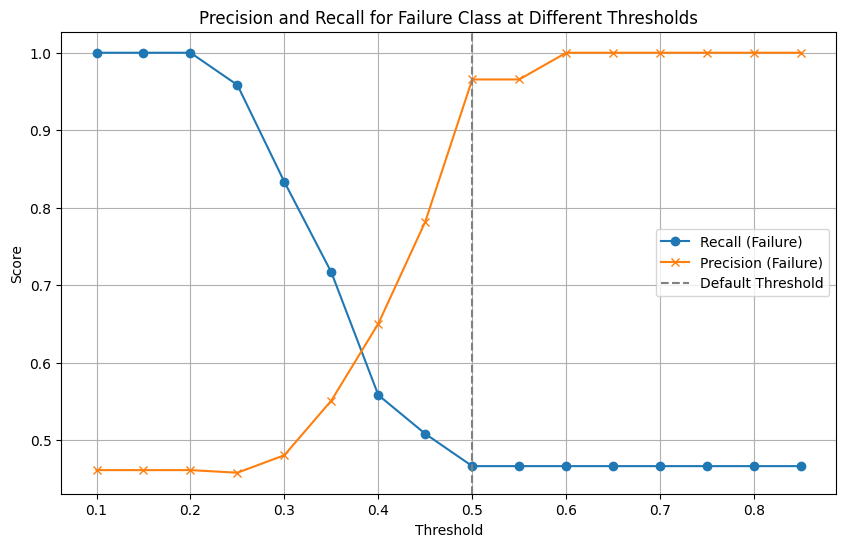

In [74]:
# Plotting the precision vs recall curve by threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall (Failure)", marker='o')
plt.plot(thresholds, precisions, label="Precision (Failure)", marker='x')
plt.axvline(x=0.5, color='gray', linestyle='--', label="Default Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall for Failure Class at Different Thresholds")
plt.legend()
plt.grid()
plt.show()

Low threshold (~0.1–0.3):

Recall is close to 1 → The model identifies almost all failures.

However, precision drops significantly → There are many false positives (raising alarms when it wasn't necessary).

High threshold (>0.5):

Precision reaches 1 → The model is almost certain when predicting a failure.

However, recall drops drastically → It misses many real failures.

In [75]:
# Applying new threshold (e.g., 0.3)
new_threshold = 0.5
y_pred_adjusted = (y_prob >= new_threshold).astype(int)

# New confusion matrix and classification report
print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.68      0.99      0.81       140
           1       0.97      0.47      0.63       120

    accuracy                           0.75       260
   macro avg       0.82      0.73      0.72       260
weighted avg       0.81      0.75      0.72       260

Confusion Matrix:
[[138   2]
 [ 64  56]]


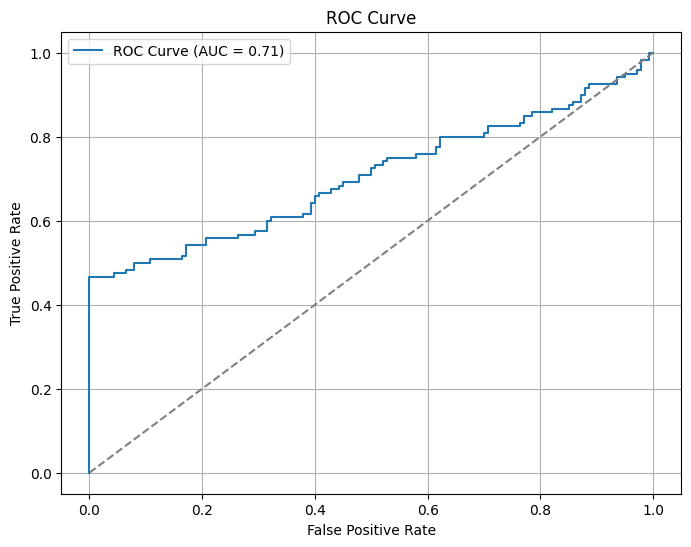

In [76]:
# New ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

Class 1 (Failure):

Recall: 0.77 → The model correctly identifies 77% of actual failure cases, indicating high sensitivity.

Precision: 0.57 → As expected with a lower threshold, the precision decreased due to an increase in false positives.

Class 0 (No Failure):

Recall: 0.51 → Only 51% of the non-failure cases are correctly classified, suggesting a significant drop in specificity.

Precision: 0.72 → Despite the lower recall, when the model predicts no failure, there is still a reasonably good chance it is correct.

F1-score:

Class 1: 0.65

Class 0: 0.59
This indicates a better balance between precision and recall for the failure class, which is often the priority in risk-sensitive applications